In [13]:
import sys
import os
import os.path
import random
from time import time
from datetime import datetime

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-bright')

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.tools as tls

from wordcloud import WordCloud

import nltk
from nltk.corpus import words,stopwords
from nltk.tokenize import sent_tokenize,word_tokenize,WordPunctTokenizer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score,accuracy_score,confusion_matrix,classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler,scale

# I. Market Data EDA

In [2]:
df_market = pd.read_csv('../analysis/data/GOOG_market.csv')
df_market.head()

date    close     volume     open       high      low
0  2019/07/26  1250.41  4805752.0  1224.04  1265.5499  1224.00
1  2019/07/25  1132.12  2209823.0  1137.82  1141.7000  1120.92
2  2019/07/24  1137.81  1590101.0  1131.90  1144.0000  1126.99
3  2019/07/23  1146.21  1093688.0  1144.00  1146.9000  1131.80
4  2019/07/22  1138.07  1301846.0  1133.45  1139.2500  1124.24

In [3]:
df_market.shape

(756, 6)

In [4]:
df_market.date = pd.to_datetime(df_market['date'])
df_market.date.dtype

dtype('<M8[ns]')

In [5]:
df_market['movement'] = 0

In [6]:
for index in range(0,df_market.shape[0]-1):
    ct = float(df_market.loc[index,['close']])
    ct_1 = float(df_market.loc[index + 1,['close']])
    if ct < ct_1:
        df_market.loc[index + 1,['movement']] = 1
    elif ct > ct_1:
        df_market.loc[index + 1,['movement']] = -1
    else:
        df_market.loc[index + 1,['']] = 0

In [7]:
start_date = datetime.strptime('2017-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2019-07-01', '%Y-%m-%d')
mask = (df_market['date'] >= start_date) & (df_market['date'] <= end_date)
df_market = df_market.loc[mask]

In [8]:
df_market.tail()

date   close     volume    open      high       low  movement
640 2017-01-09  806.65  1274318.0  806.40  809.9664  802.8300         1
641 2017-01-06  806.15  1639246.0  795.26  807.9000  792.2041        -1
642 2017-01-05  794.02  1334028.0  786.08  794.4800  785.0200        -1
643 2017-01-04  786.90  1071198.0  788.36  791.3400  783.1600        -1
644 2017-01-03  786.14  1657291.0  778.81  789.6300  775.8000        -1

In [9]:
df_market.describe()

close        volume         open         high          low  \
count   627.000000  6.270000e+02   627.000000   627.000000   627.000000   
mean   1041.508581  1.573490e+06  1041.129195  1050.241993  1031.911343   
std     120.628139  6.884934e+05   120.680154   122.433192   118.807655   
min     786.140000  5.369960e+05   778.810000   789.630000   775.800000   
25%     948.310000  1.158025e+06   948.940000   953.115000   941.400000   
50%    1055.810000  1.391232e+06  1056.490000  1069.210000  1045.910000   
75%    1132.415000  1.811618e+06  1131.200000  1141.410000  1118.550000   
max    1287.580000  6.194691e+06  1274.000000  1289.270000  1266.294900   

         movement  
count  627.000000  
mean    -0.084530  
std      0.997217  
min     -1.000000  
25%     -1.000000  
50%     -1.000000  
75%      1.000000  
max      1.000000

In [10]:
# # Draw the line
# fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi=80)
# ax.plot(df_market['date'],df_market['close'], color='tab:red')

# # Decorations
# ax.set_xlabel('Date')
# ax.set_ylabel('Close Price')
# ax.set_title('Close Price of GOOG(2016/09 to 2019/07)')
# fig.tight_layout()
# plt.show()

In [11]:
market_data = []
market_data.append(go.Scatter(
        x = df_market['date'].dt.strftime(date_format='%Y-%m-%d').values,
        y = df_market['close'].values,
        name = 'GOOG'
    ))
layout = go.Layout(dict(title = "Closing prices of GOOG (2017-01-03 to 2019-07-01)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Close Price (USD)'),
                  ),legend=dict(
                orientation="h"),
                  xaxis_rangeslider_visible=True)
py.iplot(dict(data=market_data, layout=layout), filename='market_data_line')

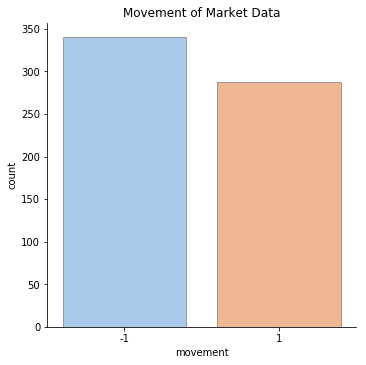

In [12]:
sns.catplot(x='movement', kind='count', palette='pastel', edgecolor='.6', data=df_market)
plt.title('Movement of Market Data')
plt.show()

In [83]:
def zscore(x,window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddpf=0).shift(1)
    z = (x-m)/s
    return z

<class 'pandas.core.series.Series'>


<Figure size 3600x360 with 0 Axes>

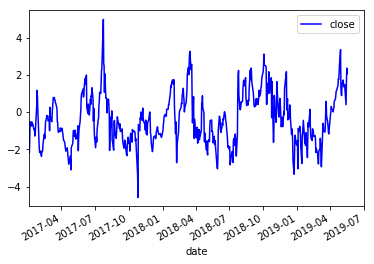

In [122]:
# Normalization
print(type(df_market.set_index(['date'])['close']))
N = 30
roll_market = df_market.set_index(['date'])[['close']]
res = zscore(roll_market, N)
ax = plt.figure(figsize=(50,5))
res.plot(style='b')

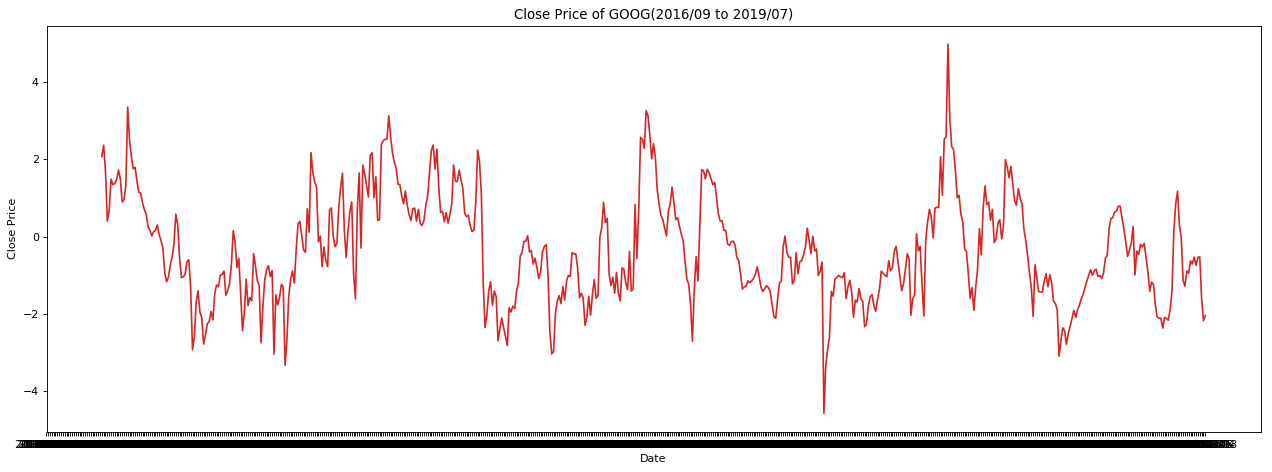

In [123]:
# Draw the line
fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi=80)
ax.plot(res.index.strftime(date_format='%Y-%m-%d').values,res.values.reshape(res.values.size,1), color='tab:red')

# Decorations
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Close Price of GOOG(2016/09 to 2019/07)')
fig.tight_layout()
plt.show()

In [124]:
market_zscore = []
market_zscore.append(go.Scatter(
        x = res.index.strftime(date_format='%Y-%m-%d').values,
        y = res.values.reshape(x.shape),
        name = 'GOOG_zscore'
    ))
layout = go.Layout(dict(title = "zscore of GOOG closing prices(2017-01-03 to 2019-07-01)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'zscore of Close Price'),
                  ),legend=dict(
                orientation="h"),
                  xaxis_rangeslider_visible=True)
py.iplot(dict(data=market_zscore, layout=layout), filename='market_zscore_line')

NameError: name 'x' is not defined

# II. News Data EDA

## 1.Load data

In [31]:
df_news = pd.read_csv('../analysis/data/train_GOOG_1000d.csv', header=None)

In [32]:
df_news.head()

0             1         2  \
0  GOOG  Alphabet Inc  20190724   
1  GOOG  Alphabet Inc  20190724   
2  GOOG  Alphabet Inc  20190724   
3  GOOG  Alphabet Inc  20190722   
4  GOOG  Alphabet Inc  20190722   

                                                   3  \
0  Google goes Nigerian with local accent  'infor...   
1  Mnuchin says Google's work with China does not...   
2  Big Tech faces broad U.S. Justice Department a...   
3  US STOCKS-S&P 500 climbs toward record high  e...   
4  US STOCKS-S&P 500 climbs toward record  marque...   

                                                   4       5  
0  LAGOS  July 24 Commuters making their way thro...  normal  
1  WASHINGTON Google's work with the Chinese gove...  normal  
2  WASHINGTON The U.S. Justice Department said on...  normal  
3  * Indexes: Dow +0.07%  S&P 500 +0.28%  Nasdaq ...  normal  
4  * Indexes: Dow +0.01%  S&P 500 +0.28%  Nasdaq ...  normal

In [33]:
df_news.shape

(784, 6)

In [34]:
cols_name = ['ticker','company','date','title','content','type']
df_news.columns = cols_name

In [35]:
df_news.head()

ticker       company      date  \
0   GOOG  Alphabet Inc  20190724   
1   GOOG  Alphabet Inc  20190724   
2   GOOG  Alphabet Inc  20190724   
3   GOOG  Alphabet Inc  20190722   
4   GOOG  Alphabet Inc  20190722   

                                               title  \
0  Google goes Nigerian with local accent  'infor...   
1  Mnuchin says Google's work with China does not...   
2  Big Tech faces broad U.S. Justice Department a...   
3  US STOCKS-S&P 500 climbs toward record high  e...   
4  US STOCKS-S&P 500 climbs toward record  marque...   

                                             content    type  
0  LAGOS  July 24 Commuters making their way thro...  normal  
1  WASHINGTON Google's work with the Chinese gove...  normal  
2  WASHINGTON The U.S. Justice Department said on...  normal  
3  * Indexes: Dow +0.07%  S&P 500 +0.28%  Nasdaq ...  normal  
4  * Indexes: Dow +0.01%  S&P 500 +0.28%  Nasdaq ...  normal

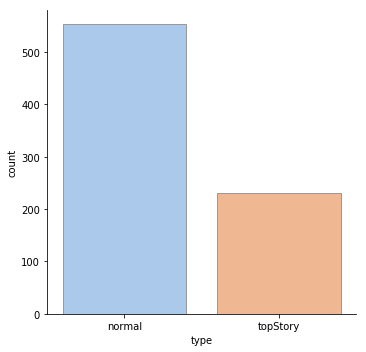

In [36]:
sns.catplot(x='type', kind='count', palette='pastel', edgecolor='.6', data=df_news)

## 2. Data preprocessing and Visualisation

In [37]:
def num_to_date(num):
    text = str(num)
    date = datetime.strptime(text, '%Y%m%d')
    return date

df_news['date'] = df_news['date'].apply(lambda row: num_to_date(row))

In [38]:
df_news['date'].head()

0   2019-07-24
1   2019-07-24
2   2019-07-24
3   2019-07-22
4   2019-07-22
Name: date, dtype: datetime64[ns]

In [39]:
news_mask = (df_news['date'] >= start_date) & (df_news['date'] <= end_date)
df_news = df_news.loc[news_mask]

In [40]:
df_news.tail()

ticker       company       date  \
766   GOOG  Alphabet Inc 2017-01-26   
767   GOOG  Alphabet Inc 2017-01-26   
768   GOOG  Alphabet Inc 2017-01-26   
769   GOOG  Alphabet Inc 2017-01-10   
770   GOOG  Alphabet Inc 2017-01-04   

                                                 title  \
766  BRIEF-Alphabet Inc reports 4th-qtr non-GAAP EP...   
767         Alphabet quarterly revenue rises 22.2 pct    
768  BRIEF-Alphabet Inc quarterly results press rel...   
769  RPT-UPDATE 1-Italy looking at Google proposal ...   
770  U.S. Labor department sues Google for compensa...   

                                               content      type  
766  * Qtrly non-GAAP diluted EPS for class A and B...  topStory  
767  Jan 26 Google parent Alphabet Inc  reported a ...    normal  
768  Please click on the link below for Alphabet In...    normal  
769  MILAN  Jan 10 Italy's tax authorities are look...  topStory  
770  The U.S. Department of Labor said on Wednesday...  topStory

In [41]:
df_news.head()

ticker       company       date  \
14   GOOG  Alphabet Inc 2019-06-28   
15   GOOG  Alphabet Inc 2019-06-28   
16   GOOG  Alphabet Inc 2019-06-27   
17   GOOG  Alphabet Inc 2019-06-27   
18   GOOG  Alphabet Inc 2019-06-25   

                                                title  \
14  Google announces new subsea cable 'Equiano'  c...   
15  Google announces new subsea cable "Equiano"  c...   
16  Google Cloud absorbs Alphabet cybersecurity fi...   
17  Google Cloud absorbs Alphabet cybersecurity fi...   
18  Factbox: Alphabet unveils Toronto smart city m...   

                                              content      type  
14  Alphabet Inc's Google on Friday announced a ne...  topStory  
15  June 28 Alphabet Inc's Google on Friday announ...    normal  
16  SAN FRANCISCO Alphabet Inc announced on Thursd...  topStory  
17  SAN FRANCISCO  June 27 Alphabet Inc announced ...    normal  
18  Alphabet on Monday released details of a propo...  topStory

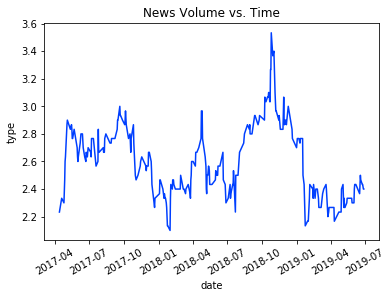

In [42]:
news_volume = df_news.groupby('date')['type'].count().reset_index()
news_volume = news_volume.set_index('date').rolling(30).mean()
sns.lineplot(x=news_volume.index, y=news_volume['type'])
plt.title('News Volume vs. Time')
plt.xticks(rotation=30)
plt.show()

### 2.1 Build a new stopwords list

In [43]:
auditor_sw = []
with open('data/wordlist/StopWords_Auditor.txt','r') as fa:
    lines = fa.readlines()
    for line in lines:
        auditor_sw.append(line.strip())

In [44]:
datesAndNum_sw = []
with open('data/wordlist/StopWords_DatesandNumbers.txt','r') as fdn:
    lines = fdn.readlines()
    for line in lines:
        datesAndNum_sw.append(line.strip())

In [45]:
generic_sw = []
with open('data/wordlist/StopWords_Generic.txt','r') as fg:
    lines = fg.readlines()
    for line in lines:
        generic_sw.append(line.strip())

In [46]:
glong_sw = []
with open('data/wordlist/StopWords_GenericLong.txt','r') as fgl:
    lines = fgl.readlines()
    for line in lines:
        glong_sw.append(line.strip())

In [47]:
geographic_sw = []
with open('data/wordlist/StopWords_Geographic.txt','r') as fgeo:
    lines = fgeo.readlines()
    for line in lines:
        geographic_sw.append(line.strip())

In [48]:
new_stopwords = auditor_sw + datesAndNum_sw + generic_sw + glong_sw + geographic_sw

### 2.2 Clean the news data

In [49]:
def datacleaner(text):
    stemmer = PorterStemmer()
#     lemmatizer = WordNetLemmatizer()
    wps = WordPunctTokenizer().tokenize(text)
    wps = [w for w in wps if w not in stopwords.words('english')] # remove buit-in stopwords
    wps = [w for w in wps if w not in new_stopwords] # remove 
    words = [w.lower() for w in wps if w.isalpha()] # lower case and remove punctuation
#     words = [lemmatizer.lemmatize(w, pos='n') for w in words] # Lemmatisation
    words = [stemmer.stem(w) for w in words] # Normalisation,Stemming
    
    return words

In [50]:
df_news2 = df_news.copy()

In [51]:
df_news2['content'] = df_news2['content'].apply(lambda row: datacleaner(row))

In [52]:
df_news2['content'].head(20)

14    [alphabet, inc, googl, friday, announc, subsea...
15    [june, alphabet, inc, googl, friday, announc, ...
16    [francisco, alphabet, inc, announc, thursday, ...
17    [francisco, june, alphabet, inc, announc, thur...
18    [alphabet, monday, releas, detail, propos, sma...
19    [amsterdam, june, alphabet, inc, googl, monday...
20    [pari, june, french, automak, renault, sa, jap...
21    [francisco, sharehold, activist, wednesday, ur...
22    [francisco, june, sharehold, activist, wednesd...
23    [francisco, june, sharehold, activist, googl, ...
24    [june, the, top, stori, new, york, time, busi,...
25    [alphabet, inc, googl, calendar, app, user, un...
26    [june, alphabet, inc, googl, announc, tuesday,...
27    [june, alphabet, inc, googl, calendar, app, us...
28    [june, collect, health, make, softwar, compani...
29    [alphabet, inc, googl, warn, u, s, administr, ...
30    [june, alphabet, inc, googl, warn, u, s, admin...
31    [alphabet, inc, googl, thursday, buy, look

In [53]:
df_news2['title'] = df_news2['title'].apply(lambda row: datacleaner(row))

14    [googl, announc, subsea, cabl, equiano, connec...
15    [googl, announc, subsea, cabl, equiano, connec...
16    [googl, cloud, absorb, alphabet, cybersecur, f...
17    [googl, cloud, absorb, alphabet, cybersecur, f...
18    [factbox, alphabet, unveil, toronto, smart, ci...
19    [googl, spend, bln, euro, build, dutch, data, ...
20    [renault, nissan, join, waymo, explor, driverl...
21           [activist, urg, googl, break, regul, forc]
22    [updat, activist, urg, googl, break, regul, forc]
23           [activist, urg, googl, break, regul, forc]
24    [press, digest, new, york, time, busi, news, j...
25                       [googl, calendar, app, global]
26    [updat, googl, invest, bln, eas, hous, shortag...
27                       [googl, calendar, app, global]
28    [collect, health, secur, mln, fund, led, softb...
29    [googl, flag, u, s, nation, secur, risk, huawe...
30    [googl, flag, u, s, nation, secur, risk, huawe...
31    [googl, buy, analyt, softwar, firm, looker

### 2.3 Concatenate the title and content into one document

In [55]:
# 合并title and content
df_news2['text'] = df_news2['title'] + df_news2['content']
df_news2['text'].head(20)

14    [googl, announc, subsea, cabl, equiano, connec...
15    [googl, announc, subsea, cabl, equiano, connec...
16    [googl, cloud, absorb, alphabet, cybersecur, f...
17    [googl, cloud, absorb, alphabet, cybersecur, f...
18    [factbox, alphabet, unveil, toronto, smart, ci...
19    [googl, spend, bln, euro, build, dutch, data, ...
20    [renault, nissan, join, waymo, explor, driverl...
21    [activist, urg, googl, break, regul, forc, fra...
22    [updat, activist, urg, googl, break, regul, fo...
23    [activist, urg, googl, break, regul, forc, fra...
24    [press, digest, new, york, time, busi, news, j...
25    [googl, calendar, app, global, alphabet, inc, ...
26    [updat, googl, invest, bln, eas, hous, shortag...
27    [googl, calendar, app, global, june, alphabet,...
28    [collect, health, secur, mln, fund, led, softb...
29    [googl, flag, u, s, nation, secur, risk, huawe...
30    [googl, flag, u, s, nation, secur, risk, huawe...
31    [googl, buy, analyt, softwar, firm, looker

### 2.4 Visualize the frequency of the words

In [56]:
text_wl = []
for index,row in df_news2.iterrows():
    for word in row['text']:
        text_wl.append(word)

text_wl = list(set(text_wl))
whole_text = ' '.join(text_wl)

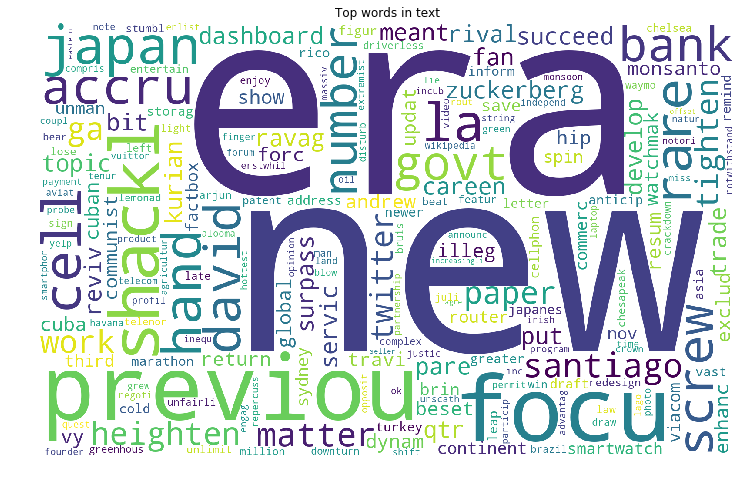

In [57]:
wc = WordCloud(background_color='white',
              max_font_size=None,
              width=1600,
              height=1000)
wc.generate(whole_text)
plt.figure(figsize=(16,8))
plt.imshow(wc)
plt.title('Top words in text')
plt.axis('off')
plt.show()

## 3. Build the polarity dictionary

### 3.1 Financial sentiment word list

In [58]:
financial_sheets = pd.read_excel('data/wordlist/LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name=['Negative','Positive'])

In [59]:
financial_sheets['Negative'].head()

ABANDON
0     ABANDONED
1    ABANDONING
2   ABANDONMENT
3  ABANDONMENTS
4      ABANDONS

In [60]:
stemmer = PorterStemmer()

In [61]:
path = 'data/wordlist/negative-words.txt'
general_neg = []
with open(path, 'r', encoding='ISO-8859-1') as f:
    ls = f.readlines()
    for word in ls:
        general_neg.append(word.strip())

In [62]:
print(general_neg[:20])

['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade', 'abrasive', 'abrupt', 'abruptly', 'abscond', 'absence', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'absurdly']


In [63]:
# 创建negative_words字典
neg_dict = financial_sheets['Negative'].values
neg_dict = neg_dict.reshape(1, len(neg_dict)).tolist()[0]
neg_dict = neg_dict + general_neg
neg_dict = list(map(lambda x:x.lower(),neg_dict))
neg_dict = list(set([stemmer.stem(w) for w in neg_dict]))
print(neg_dict[:20])

['heavy-hand', 'flaki', 'unreport', 'interfer', 'lascivi', 'breakdown', 'mad', 'insurmount', 'jolt', 'viper', 'miscommun', 'screw', 'pompou', 'martyrdom-seek', 'pokey', 'disapoint', 'smut', 'cumbersom', 'assult', 'tighten']


In [64]:
path = 'data/wordlist/positive-words.txt'
general_pos = []
with open(path, 'r', encoding='ISO-8859-1') as f:
    ls = f.readlines()
    for word in ls:
        general_pos.append(word.strip())

In [65]:
# 创建positive_words字典
pos_dict = financial_sheets['Positive'].values
pos_dict = pos_dict.reshape(1, len(pos_dict)).tolist()[0]
pos_dict = pos_dict + general_pos
pos_dict = list(map(lambda x:x.lower(),pos_dict))
pos_dict = list(set([stemmer.stem(w) for w in pos_dict]))
print(pos_dict[:20])

['nicest', 'pluss', 'happili', 'dazzl', 'hearten', 'reform', 'genial', 'appropri', 'bliss', 'work', 'stainless', 'lover', 'enough', 'succeed', 'classic', 'reviv', 'better-known', 'catchi', 'surpass', 'exult']


## 4. Calculate daily sentiment score

In [66]:
def daily_sentiment_score(word_list):
    '''统计pos/neg单词个数并计算daily_sent_score'''
    poscount = 0
    negcount = 0
    score = 0
    for word in word_list:
        if word in pos_dict:
            poscount += 1
        elif word in neg_dict:
            negcount += 1
    if poscount > negcount:
        score = 2 * poscount / (poscount + negcount) - 1
    elif poscount == negcount:
        score = 0
    else:
        score = 1 - 2 * negcount / (poscount + negcount)
    return score

In [67]:
def group_news_bydate(df):
    daily_news_text = []
    for index, row in df.iterrows(): 
        daily_news_text += row['text']
    daily_sent_score = daily_sentiment_score(daily_news_text)
    return daily_sent_score

In [68]:
df_daily = df_news2.groupby(['date']).apply(group_news_bydate)

In [69]:
def group_news_bydate2(df):
    group_text = ''
    for index, row in df.iterrows():
        this_text = row['title'] + row['content']
        group_text += this_text
    return group_text

In [70]:
daily_text = df_news.groupby(['date']).apply(group_news_bydate2)
daily_text.head()

date
2017-01-04    U.S. Labor department sues Google for compensa...
2017-01-10    RPT-UPDATE 1-Italy looking at Google proposal ...
2017-01-26    BRIEF-Alphabet Inc reports 4th-qtr non-GAAP EP...
2017-01-27    Alphabet's hardware growth adds to strength in...
2017-02-02    UPDATE 2-Microsoft asks for exception program ...
dtype: object

In [71]:
index = df_daily.index
documents = daily_text.values
scores = df_daily.values

d = {'text':documents, 'sent_score':scores}
new_dataset = pd.DataFrame(data=d, index=index)
new_dataset.head()

text  sent_score
date                                                                     
2017-01-04  U.S. Labor department sues Google for compensa...    0.333333
2017-01-10  RPT-UPDATE 1-Italy looking at Google proposal ...   -1.000000
2017-01-26  BRIEF-Alphabet Inc reports 4th-qtr non-GAAP EP...    0.000000
2017-01-27  Alphabet's hardware growth adds to strength in...    0.294118
2017-02-02  UPDATE 2-Microsoft asks for exception program ...    0.500000

In [72]:
# # Draw the line
# fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi=80)
# ax.plot(news_by_date.index, news_by_date.sent_score, color='tab:red')

# # Decorations
# ax.set_xlabel('Date')
# ax.set_ylabel('Sentiment Score')
# ax.set_title('Sentiment Score of GOOG(2016/09 to 2019/07)')
# fig.tight_layout()
# plt.show()

In [73]:
sent_score = []
sent_score.append(go.Scatter(
        x = new_dataset.index.strftime(date_format='%Y-%m-%d').values,
        y = new_dataset.sent_score,
        name = 'GOOG'
    ))
layout = go.Layout(dict(title = "Sentiment Score of GOOG (2017-01-04 to 2018-12-21)",
                  xaxis = dict(title = 'Date'),
                  yaxis = dict(title = 'Sentiment Score'),
                  ),legend=dict(
                orientation="h"),
                  xaxis_rangeslider_visible=True)
py.iplot(dict(data=sent_score, layout=layout), filename='sent_score_line')

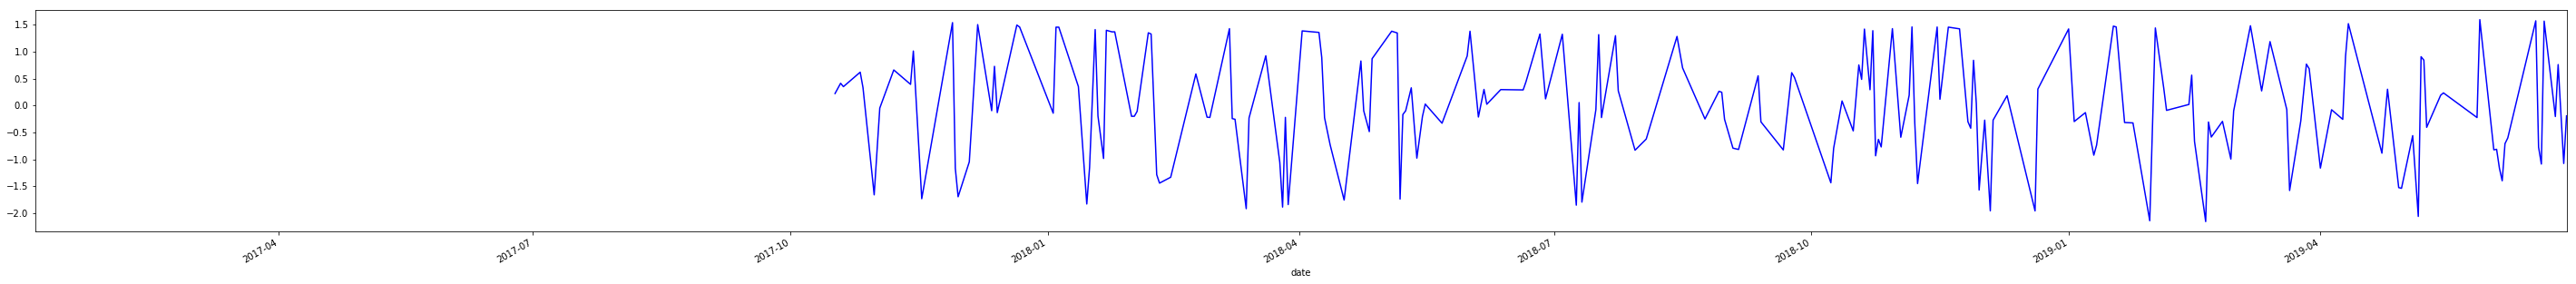

In [120]:
# Normalization
N = 90
roll_sent = new_dataset['sent_score']
res2 = zscore(roll_sent, N)
ax = plt.figure(figsize=(50,5))
res2.plot(style='b')

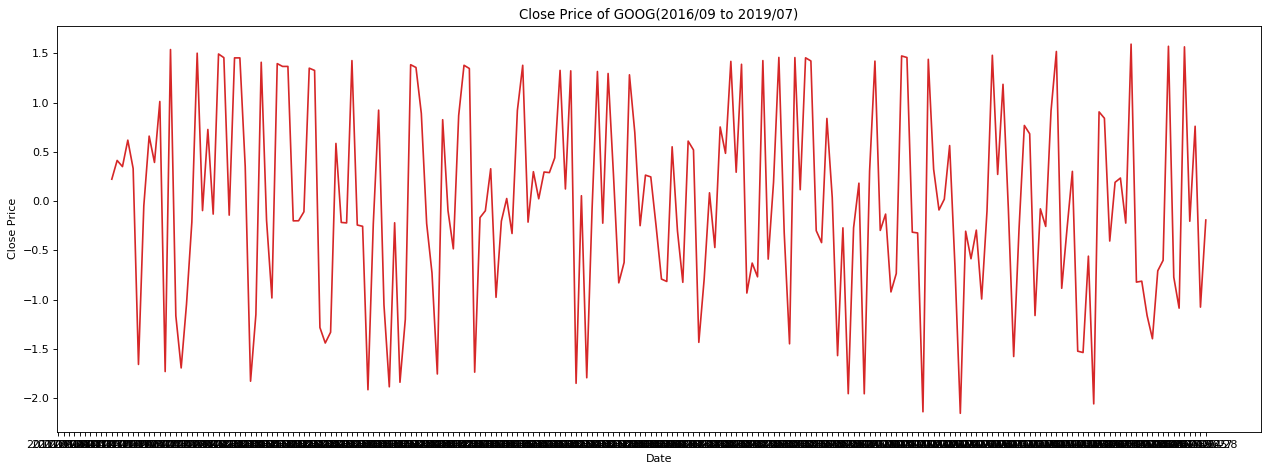

In [121]:
# Draw the line
fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi=80)
ax.plot(res2.index.strftime(date_format='%Y-%m-%d').values,res2.values.reshape(res.values.size,1), color='tab:red')

# Decorations
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Close Price of GOOG(2016/09 to 2019/07)')
fig.tight_layout()
plt.show()

In [127]:
def add_label(s):
    if s < 0:
        return -1
    elif s > 0:
        return 1
    else:
        return 0

In [128]:
new_dataset['label'] = new_dataset['sent_score'].apply(lambda row: add_label(row))

In [129]:
new_dataset.head()

text  sent_score  \
date                                                                        
2017-01-04  U.S. Labor department sues Google for compensa...    0.333333   
2017-01-10  RPT-UPDATE 1-Italy looking at Google proposal ...   -1.000000   
2017-01-26  BRIEF-Alphabet Inc reports 4th-qtr non-GAAP EP...    0.000000   
2017-01-27  Alphabet's hardware growth adds to strength in...    0.294118   
2017-02-02  UPDATE 2-Microsoft asks for exception program ...    0.500000   

            label  
date               
2017-01-04      1  
2017-01-10     -1  
2017-01-26      0  
2017-01-27      1  
2017-02-02      1

In [130]:
new_dataset.shape

(296, 3)

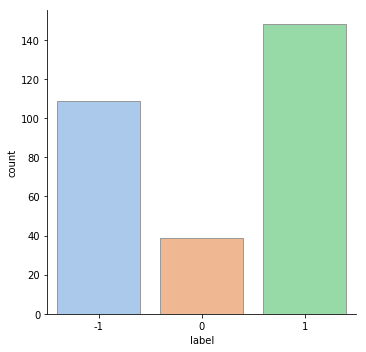

In [131]:
sns.catplot(x='label', kind='count', palette='pastel', edgecolor='.6', data=new_dataset)

## 5. Check the Accuracy of Detection Result

In [132]:
new_df_market = df_market.set_index('date')
new_df_market.head()


close     volume     open     high       low  movement
date                                                                
2019-07-01  1097.95  1438504.0  1098.00  1107.58  1093.703        -1
2019-06-28  1080.91  1693450.0  1076.39  1081.00  1073.370        -1
2019-06-27  1076.01  1004477.0  1084.00  1087.10  1075.290        -1
2019-06-26  1079.80  1810869.0  1086.50  1092.97  1072.240         1
2019-06-25  1086.35  1546913.0  1112.66  1114.35  1083.800         1

In [135]:
merge_label = pd.merge(new_dataset[['sent_score','label']], new_df_market[['close','movement']], how='inner',left_index=True,right_index=True)
merge_label.head(20)

sent_score  label   close  movement
date                                           
2017-01-04    0.333333      1  786.90        -1
2017-01-10   -1.000000     -1  804.79        -1
2017-01-26    0.000000      0  832.15         1
2017-01-27    0.294118      1  823.31         1
2017-02-02    0.500000      1  798.53        -1
2017-02-03   -0.200000     -1  801.49         1
2017-02-10   -1.000000     -1  813.67        -1
2017-02-14   -1.000000     -1  820.45         1
2017-02-16    1.000000      1  824.16        -1
2017-02-17   -0.250000     -1  828.07        -1
2017-02-22    0.428571      1  830.76        -1
2017-02-24   -0.600000     -1  828.64        -1
2017-02-28   -0.800000     -1  823.21        -1
2017-03-01   -0.500000     -1  835.24         1
2017-03-06    0.333333      1  827.78        -1
2017-03-07    0.263158      1  831.91        -1
2017-03-10   -0.750000     -1  843.25        -1
2017-03-15    1.000000      1  847.20        -1
2017-03-17   -0.555556     -1  852.12         1
2017-03-22    1.000000      1  829.59         1

In [136]:
correct = 0
mistake = 0
acc = 0

# new_df_market.index
# new_dataset.index
for index, row in merge_label.iterrows():
    if row['label'] == row['movement']:
        correct += 1
    else:
        mistake += 1
acc = correct / (correct + mistake)
print(acc)

0.4036363636363636


In [140]:
N = 90
roll_market = merge_label['close']
roll_sent = merge_label['sent_score']
res_market = zscore(roll_market, N)
res_sent = zscore(roll_sent, N)

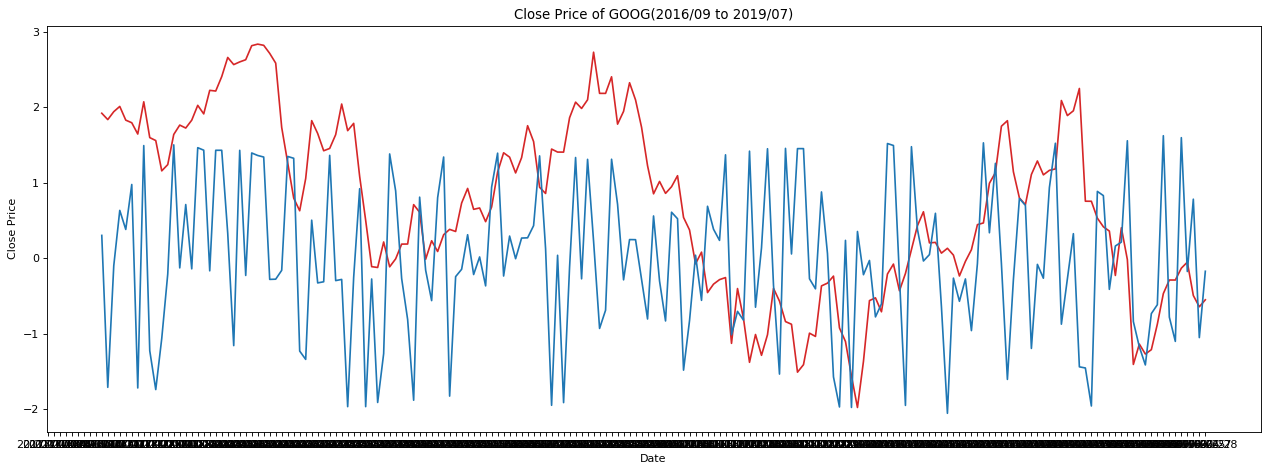

In [141]:
# Draw the line
fig, ax = plt.subplots(1, 1, figsize=(16,6), dpi=80)
ax.plot(res_market.index.strftime(date_format='%Y-%m-%d').values,res_market.values.reshape(res_market.values.size,1), color='tab:red')
ax.plot(res_sent.index.strftime(date_format='%Y-%m-%d').values,res_sent.values.reshape(res_sent.values.size,1), color='tab:blue')

# Decorations
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.set_title('Close Price of GOOG(2016/09 to 2019/07)')
fig.tight_layout()
plt.show()

## 6. Document Representation

In [64]:
text = new_dataset['text']
target = new_dataset['label']
train_set, test_set, train_target, test_target = train_test_split(text, target, random_state=1, test_size=0.3)

In [65]:
print(train_set.shape, train_target.shape)

(207,) (207,)


In [66]:
print(test_set.shape, test_target.shape)

(89,) (89,)


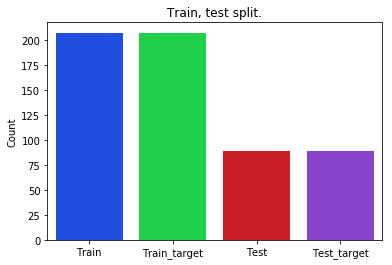

In [67]:
sns.barplot(['Train','Train_target','Test','Test_target'],[train_set.size, train_target.size, test_set.size, 
                                                           test_target.size])
plt.title('Train, test split.')
plt.ylabel('Count')
plt.show()

In [68]:
vectorizer = TfidfVectorizer(max_df=0.9,min_df=0.01,max_features=1000,
                             tokenizer=datacleaner, use_idf=True,ngram_range=(1,1))

In [69]:
train_tfidf_vec = vectorizer.fit_transform(train_set.values)

In [70]:
words = vectorizer.get_feature_names()
test_tfidf_vec = vectorizer.transform(test_set.values)

In [71]:
print(train_tfidf_vec)
print(train_tfidf_vec.todense())

  (0, 591)	0.27905830743484805
  (0, 253)	0.21262783318968947
  (0, 168)	0.2562057852760379
  (0, 545)	0.6378834995690683
  (0, 23)	0.06941410432579084
  (0, 573)	0.23335326311722762
  (0, 608)	0.22204321097471547
  (0, 482)	0.1654958454522689
  (0, 523)	0.31043994756907356
  (0, 103)	0.27905830743484805
  (0, 510)	0.23999166276850264
  (0, 228)	0.1912393220314461
  (1, 5)	0.255278790115511
  (1, 578)	0.1662646905058777
  (1, 251)	0.17528424658717698
  (1, 514)	0.18920491255251798
  (1, 79)	0.2080106290890429
  (1, 18)	0.255278790115511
  (1, 534)	0.23711203762858793
  (1, 504)	0.11279125002199349
  (1, 241)	0.11279125002199349
  (1, 598)	0.24543491524319877
  (1, 43)	0.22990243310548203
  (1, 301)	0.22990243310548203
  (1, 547)	0.22990243310548203
  :	:
  (206, 421)	0.06818656062957162
  (206, 575)	0.08250475388585515
  (206, 105)	0.07999612272253592
  (206, 345)	0.1516079268856959
  (206, 618)	0.12031248779919944
  (206, 311)	0.17765199912583235
  (206, 189)	0.08540075602932783
  (20

## 7. Classifier Learning

### 7.1 Naive-Bayes Classifier

In [72]:
clf_NB = MultinomialNB()
clf_NB.fit(train_tfidf_vec, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [73]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_NB.score(train_tfidf_vec.toarray(), train_target), clf_NB.score(test_tfidf_vec.toarray(), test_target)))

The accuracy score of Naive-Bayes: 

	Train data set:  0.811594, 	Test data set:  0.651685


In [74]:
clf_NB2 = GaussianNB()
clf_NB2.fit(train_tfidf_vec.toarray(), train_target)

GaussianNB(priors=None, var_smoothing=1e-09)

In [75]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_NB2.score(train_tfidf_vec.toarray(), train_target), clf_NB2.score(test_tfidf_vec.toarray(), test_target)))

The accuracy score of Naive-Bayes: 

	Train data set:  0.951691, 	Test data set:  0.617978


### 7.2 Random Forest Classifier

In [76]:

clf_RF = RandomForestClassifier(n_estimators=100, max_depth = 25, min_samples_leaf= 3, 
                             min_samples_split=3, random_state = 1, n_jobs = -1, verbose = 1)
clf_RF.fit(train_tfidf_vec, train_target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=1, warm_start=False)

In [77]:
print('The accuracy score of Naive-Bayes: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_RF.score(train_tfidf_vec, train_target), clf_RF.score(test_tfidf_vec, test_target)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


The accuracy score of Naive-Bayes: 

	Train data set:  0.859903, 	Test data set:  0.606742


### 7.3 SVM

In [78]:
clf_SVM = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, C=1.0, random_state=1)
clf_SVM.fit(train_tfidf_vec, train_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0)

In [79]:
print('The accuracy score of SVM: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_SVM.score(train_tfidf_vec, train_target), clf_SVM.score(test_tfidf_vec, test_target)))

The accuracy score of SVM: 

	Train data set:  1.000000, 	Test data set:  0.595506


### 7.4 KNN

In [80]:
clf_KNN = KNeighborsClassifier(n_neighbors=3)
clf_KNN.fit(train_tfidf_vec, train_target)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [81]:
print('The accuracy score of KNN: \n\n\tTrain data set:  %f, \tTest data set:  %f' % \
     (clf_KNN.score(train_tfidf_vec, train_target), clf_KNN.score(test_tfidf_vec, test_target)))

The accuracy score of KNN: 

	Train data set:  0.743961, 	Test data set:  0.550562


### 7.5 LSTM

In [82]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.utils import Sequence
import gc

Using TensorFlow backend.


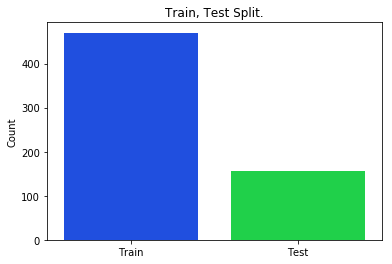

date   close  movement
483 2017-08-23  927.00         1
484 2017-08-22  924.69        -1
485 2017-08-21  906.66        -1
486 2017-08-18  910.67         1
487 2017-08-17  910.98         1

In [86]:
def market_train_test_split(market):
    market_idx = market[['date','close','movement']]
    market_train_idx, market_test_idx = train_test_split(market_idx,shuffle=False,random_state=24)
    return (market_train_idx,market_test_idx)

market_train_idx, market_test_idx = market_train_test_split(df_market)

sns.barplot(['Train','Test'], [market_train_idx.index.size, market_test_idx.index.size])
plt.title('Train, Test Split.')
plt.ylabel('Count')
plt.show()

market_train_idx.tail()

In [94]:
class MarketPrepro():
    time_cols = ['year','week','day','dayofweek']
    numeric_cols = ['close','volume','open','high','low']
    
    feature_cols = [] + time_cols + numeric_cols
    label_cols = ['movement']
    
    def __init__(self):
        self.cats = {}
        self.numeric_scaler = StandardScaler()
        
    def fit(self, market_train_idx, df_market):
        df_market_train = df_market.loc[market_train_idx.index].copy()
        df_market_train = self.fix_train(df_market_train)
        df_market_train = self.prepare_time_cols(df_market_train)
        self.numeric_scaler.fit(df_market_train[self.numeric_cols + self.time_cols])
        
    def fix_train(self, df_train):
        max_ratio = 2
        df_train = df_train[(df_train['close'] / df_train['open']).abs() <= max_ratio].loc[:]
        df_train = self.safe_fix(df_train)
        return df_train
    
    def safe_fix(self, df):
         # Fill nans
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0)
        # Fix outliers
        df[self.numeric_cols] = df[self.numeric_cols].clip(df[self.numeric_cols].quantile(0.01),
                                                           df[self.numeric_cols].quantile(0.99), axis=1)
        return df
    
    def get_X(self, df):
        df = df.copy()
        df = self.safe_fix(df)
        
        df = self.prepare_time_cols(df)
        df = df.set_index(['date'], drop=False)
        df[self.numeric_cols + self.time_cols] = self.numeric_scaler.transform(
            df[self.numeric_cols + self.time_cols].sdtype(float))
        return df[self.feature_cols]
    
    def get_y(self, df, is_raw_y=False):
        if is_raw_y:
            return df[self.label_cols]
        else:
            return (df[self.label_cols] >= 0).astype(float)
        
    @staticmethod
    def prepare_time_cols(df):
        """
        Extract time parts, they are important for time series
        """
        df['year'] = pd.to_datetime(df['date']).dt.year
        # Maybe remove month because week of year can handle the same info
        df['day'] = pd.to_datetime(df['date']).dt.day
        # Week of year
        df['week'] = pd.to_datetime(df['date']).dt.week
        df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek
        return df
    
market_prepro = MarketPrepro()
market_prepro.fit(market_train_idx, df_market)
print('market_prepro is fit')

market_prepro is fit


/Users/suhang/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



In [99]:
print(market_prepro.cats)

{}


In [95]:
df_news.head()

ticker       company       date  \
14   GOOG  Alphabet Inc 2019-06-28   
15   GOOG  Alphabet Inc 2019-06-28   
16   GOOG  Alphabet Inc 2019-06-27   
17   GOOG  Alphabet Inc 2019-06-27   
18   GOOG  Alphabet Inc 2019-06-25   

                                                title  \
14  Google announces new subsea cable 'Equiano'  c...   
15  Google announces new subsea cable "Equiano"  c...   
16  Google Cloud absorbs Alphabet cybersecurity fi...   
17  Google Cloud absorbs Alphabet cybersecurity fi...   
18  Factbox: Alphabet unveils Toronto smart city m...   

                                              content      type  
14  Alphabet Inc's Google on Friday announced a ne...  topStory  
15  June 28 Alphabet Inc's Google on Friday announ...    normal  
16  SAN FRANCISCO Alphabet Inc announced on Thursd...  topStory  
17  SAN FRANCISCO  June 27 Alphabet Inc announced ...    normal  
18  Alphabet on Monday released details of a propo...  topStory

In [ ]:
class NewsPrepro():
    feature_cols = ['title','content']
    
    def fit(self, idx, news):
        """
        Fit preprocessing scalers, encoders on given train df.
        @param idx: index with time, assetCode
        """
        # Save indices[assetCode, time, news_index] for all news
        self.all_news_idx = self.news_idx(news)

        # Get news only related to market idx
        news_idx = idx.merge(self.all_news_idx, on=['date'], suffixes=['_idx', ''])[
            ['date']]
        news_train_df = news_idx.merge(news, left_on='news_index', right_index=True, suffixes=['_idx', ''])[
            self.news_cols_numeric]

        # Numeric data normalization
        self.numeric_scaler = StandardScaler()
        news_train_df.fillna(0, inplace=True)

        # Fit scaler
        self.numeric_scaler.fit(news_train_df)
        
    def get_X(self, idx, news):
        news_idx = idx.merge(self.all_news_idx, on=['date'], suffixes=['_idx',''])[['date']]
        news_df = news_idx.merge(news, left_on='news_index',right_index=True,suffixes=['_idx',''])[['date']+self.news_cols_numeric]
        news_df = self.aggregate_news(news_df)
        
        return self.safe_fix(news_df)
    
    def safe_fix(self, news_df):
        news_df.fillna(0, inplace=True)
        if not news_df.empty:
            news_df[self.news_cols_numeric] = self.numeric_scaler.transform(news_df[self.news_cols_numeric])
        return news_df
    
    def aggregate_news(self, df):
        """
        News are rare for an asset. We get mean value for 10 days
        :param df:
        :return:
        """
        if df.empty:
            return df

        # News are rare for the asset, so aggregate them by rolling period say 10 days
        rolling_days = 10
        df_aggregated = df.groupby(['date']).reset_index(['date'])
        df_aggregated = df_aggregated.groupby('date') \
            .rolling(rolling_days, on='date') \
            .apply(np.mean, raw=False) \
            .reset_index('assetCode')
        #df_aggregated.set_index(['time', 'assetCode'], inplace=True)
        return df_aggregated

In [84]:
# Model Define
time_steps = 2
model = Sequential()
model.add(LSTM(512,return_sequences=True,activation='tanh',input_shape=(time_steps,24)))
model.add(Dropout(0.2))
model.add(LSTM(256,return_sequences=True,activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(128,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['mse'])
batch_size = 128

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [110]:
class DataGenerator(Sequence):
    def __init__(self, xSet, ySet, batch_size):
        self.x = xSet
        self.y = ySet
        #This will select indices according to ySet which we have filtered for time-stepping.
        self.indices = ySet.index.values
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.y)/self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batchY = self.y.loc[batch_indices].values
        batchX = np.empty([time_steps,self.x.shape[1]])
        for i in batch_indices:
            # Converting indices to index locations to get rows according to time steps.
            ind_loc = self.x.index.get_loc(i)
            time_step = self.x.iloc[ind_loc:ind_loc+time_steps]
            batchX = np.dstack((batchX,time_step.values))
        batchX = batchX[:,:,1:]
        batchX = batchX.reshape(self.batch_size, time_steps, batchX.shape[1])
        return batchX, batchY

In [111]:
trainGenerator = DataGenerator(train_set,train_target,batch_size)

In [112]:
model.fit_generator(generator=trainGenerator,epochs=2,steps_per_epoch=int(len(train_target)/batch_size),verbose=1,
                    shuffle=False,use_multiprocessing=False)

Epoch 1/2


IndexError: tuple index out of range

In [103]:
new_dataset.head()

text  sent_score  \
date                                                                        
2017-01-04  U.S. Labor department sues Google for compensa...    0.333333   
2017-01-10  RPT-UPDATE 1-Italy looking at Google proposal ...   -1.000000   
2017-01-26  BRIEF-Alphabet Inc reports 4th-qtr non-GAAP EP...    0.000000   
2017-01-27  Alphabet's hardware growth adds to strength in...    0.294118   
2017-02-02  UPDATE 2-Microsoft asks for exception program ...    0.500000   

            label  
date               
2017-01-04      1  
2017-01-10     -1  
2017-01-26      0  
2017-01-27      1  
2017-02-02      1

In [107]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [108]:
lstm_data = new_dataset[['text','label']]
lstm_data['text'] = lstm_data['text'].apply(lambda x: x.lower())
lstm_data['text'] = lstm_data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [109]:
print(lstm_data[lstm_data['label'] == 1].size)
print(lstm_data[lstm_data['label'] == -1].size)
print(lstm_data[lstm_data['label'] == 0].size)

296
218
78


In [112]:
for idx, row in lstm_data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_features = 2000
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(lstm_data['text'].values)
X = tokenizer.texts_to_sequences(lstm_data['text'].values)
X = pad_sequences(X)

/Users/suhang/anaconda3/lib/python3.7/site-packages/keras_preprocessing/text.py:178: UserWarning:

The `nb_words` argument in `Tokenizer` has been renamed `num_words`.



In [117]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.

/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 387, 128)          256000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
Y = pd.get_dummies(lstm_data['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(198, 387) (198, 3)
(98, 387) (98, 3)


In [ ]:
batch_size = 32
model.fit(X_train, Y_train, nb_epoch = 7, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.


/Users/suhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 1/7


### 7.5 Accuracy

In [100]:
eclf1 = VotingClassifier(estimators=[('nb',clf_NB), ('rf',clf_RF), ('svm',clf_SVM), ('knn',clf_KNN)],
    weights=[1,1,1,1], flatten_transform=True)
eclf1 = eclf1.fit(train_tfidf_vec, train_target)
target_predict_vote = eclf1.predict(test_tfidf_vec)
print(classification_report(target_predict_vote, test_target))
print(accuracy_score(target_predict_vote, test_target))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


              precision    recall  f1-score   support

          -1       0.69      0.54      0.60        41
           0       0.00      0.00      0.00         2
           1       0.69      0.72      0.70        46

   micro avg       0.62      0.62      0.62        89
   macro avg       0.46      0.42      0.43        89
weighted avg       0.67      0.62      0.64        89

0.6179775280898876


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [102]:
sent_label = go.Scatter(
        x = merge_label.index.strftime(date_format='%Y-%m-%d').values,
        y = merge_label.label,
        name = 'GOOG_sent',
        mode = 'lines+markers'
    )
market_label = go.Scatter(
        x = merge_label.index.strftime(date_format='%Y-%m-%d').values,
        y = merge_label.movement,
        name = 'GOOG_market',
        mode = 'lines+markers'
    )
# layout = go.Layout(title = "Sentiment Score of GOOG (2017-01-04 to 2018-12-21)",
#                   xaxis = dict(title = 'Date'),
#                   yaxis = dict(title = 'Label'),
#                   xaxis_rangeslider_visible=True)
py.iplot([sent_label,market_label])